In [27]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50

# Specify the folders
positive_folder = 'D:\\Github\\AI\\Computer Vision\\Face Recogniton System\\Data\\Positive'
anchor_folder = 'D:\\Github\\AI\\Computer Vision\\Face Recogniton System\\Data\\Anchor'

# List images in the folders by explicit names
positive_images = [f'{i}.jpg' for i in range(1, 536)]
anchor_images = [f'{i}.jpg' for i in range(1, 536)]
negative_images = [f'{i}.jpg' for i in range(535, 0, -1)]

pairs = []
labels = []

In [28]:
for anchor_img, pos_img, neg_img in zip(anchor_images, positive_images, negative_images):
    # Positive pair (Label 1)
    anchor_image_path = os.path.join(anchor_folder, anchor_img)
    positive_image_path = os.path.join(positive_folder, pos_img)
    pairs.append([anchor_image_path, positive_image_path])
    labels.append(1)
    
    # Negative pair (Label 0)
    negative_image_path = os.path.join(positive_folder, neg_img)
    pairs.append([anchor_image_path, negative_image_path])
    labels.append(0)

# Convert to numpy array
pairs = np.array(pairs)
labels = np.array(labels)

print(f"Total pairs created: {len(pairs)}")

Total pairs created: 1070


In [29]:
def preprocess_image(image_path):
    if not os.path.exists(image_path):
        print(f"File not found: {image_path}")
        return None
    
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return None
    
    # Convert from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize with a better interpolation method
    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
    
    # Normalize the image to [0, 1]
    image = image / 255.0
    
    return image

In [30]:
anchor_images = []
paired_images = []
filtered_labels = []

for i, pair in enumerate(pairs):
    anchor_img = preprocess_image(pair[1])
    paired_img = preprocess_image(pair[0])
    
    if anchor_img is not None and paired_img is not None:
        anchor_images.append(anchor_img)
        paired_images.append(paired_img)
        filtered_labels.append(labels[i])

# Convert lists to numpy arrays
anchor_images = np.array(anchor_images)
paired_images = np.array(paired_images)
filtered_labels = np.array(filtered_labels)

print(f"Prepared {len(anchor_images)} anchor images and {len(paired_images)} paired images.")

# Check that data cardinality matches


Prepared 1070 anchor images and 1070 paired images.


In [22]:
assert len(anchor_images) == len(paired_images) == len(filtered_labels), \
    f"Data cardinality mismatch: {len(anchor_images)}, {len(paired_images)}, {len(filtered_labels)}"


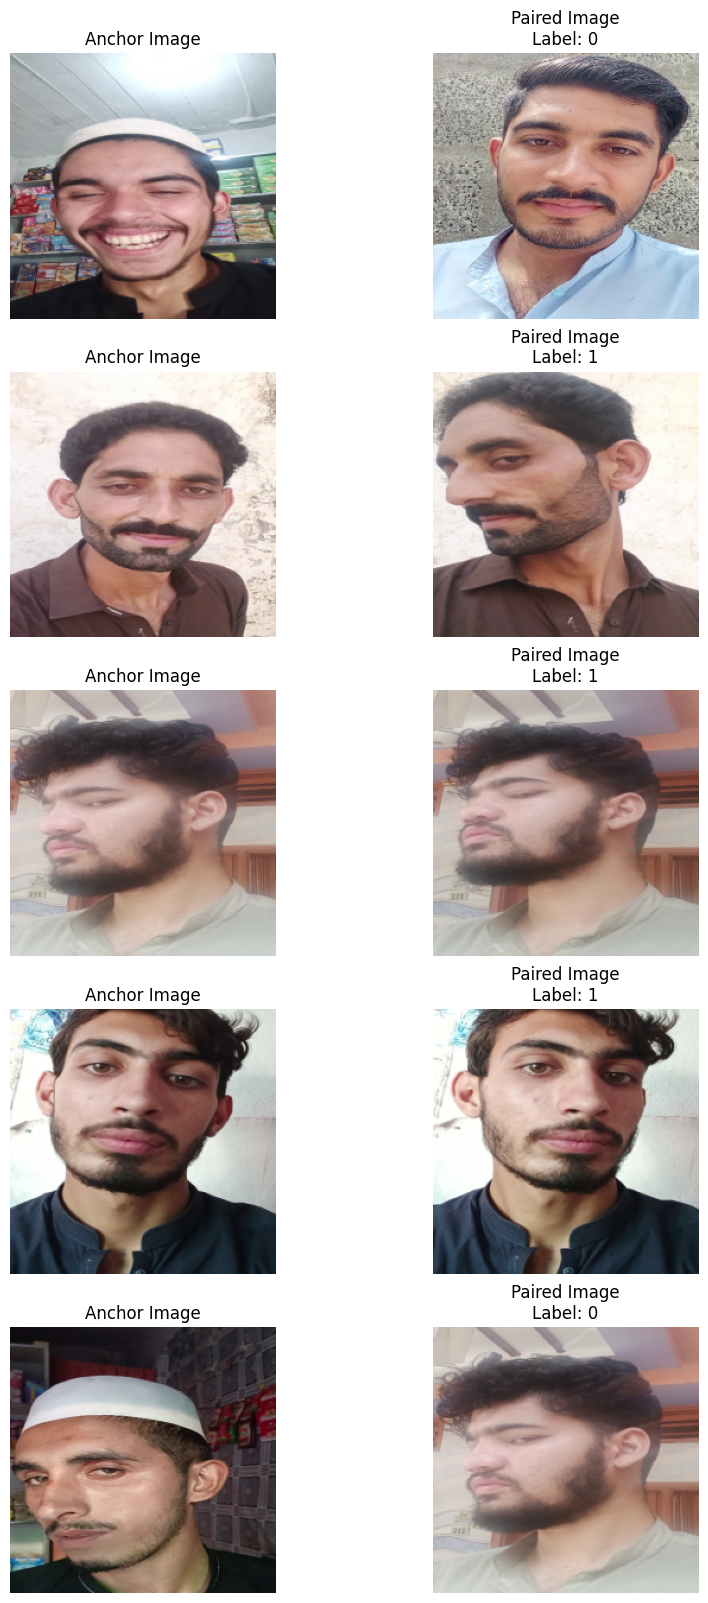

In [31]:
def visualize_pairs(pairs, labels, num_samples=5):
    """
    Function to visualize pairs of images with their labels.
    
    :param pairs: Array containing pairs of image paths.
    :param labels: Array containing labels for the pairs.
    :param num_samples: Number of pairs to visualize.
    """
    plt.figure(figsize=(10, num_samples * 4))
    
    for i in range(num_samples):
        # Randomly select an index
        idx = np.random.randint(0, len(pairs))
        
        # Load and preprocess the anchor and paired images
        anchor_image = preprocess_image(pairs[idx][1])
        paired_image = preprocess_image(pairs[idx][0])
        label = labels[idx]
        
        # Plot the anchor image
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(anchor_image)
        plt.title(f"Anchor Image")
        plt.axis('off')
        
        # Plot the paired image with its label
        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(paired_image)
        plt.title(f"Paired Image\nLabel: {label}")
        plt.axis('off')
    
    plt.show()

# Visualize the pairs
visualize_pairs(pairs, labels, num_samples=5)

In [35]:
def create_siamese_model(input_shape):
    input_layer = layers.Input(shape=input_shape)
    
    # Load a pre-trained ResNet50 model
    base_model = ResNet50(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
    
    # Feature extraction with ResNet50
    x = base_model(input_layer)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)
    
    return Model(input_layer, x)

# Set input shape and define the model
input_shape = (224, 224, 3)
anchor_input = layers.Input(name="anchor", shape=input_shape)
positive_input = layers.Input(name="positive", shape=input_shape)

siamese_network = create_siamese_model(input_shape)

encoded_anchor = siamese_network(anchor_input)
encoded_positive = siamese_network(positive_input)

In [33]:
L1_distance = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([encoded_anchor, encoded_positive])
output = layers.Dense(1, activation="sigmoid")(L1_distance)

model = Model(inputs=[anchor_input, positive_input], outputs=output)

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the Siamese Network
model.fit([anchor_images, paired_images], labels, batch_size=32, epochs=10)